Componentes básicos del A/B Testing
  1. Hipótesis: Antes de empezar, necesitas una idea clara de qué quieres probar y por qué.
Ejemplo: "Cambiar el color del botón a verde aumentará los clics en un 10%."

  2. Grupo A y Grupo B:
Grupo A (control): La versión actual.
Grupo B (variación): La versión modificada que pruebas.
⚖️ Ambos grupos deben ser similares en tamaño y características para que los resultados sean comparables.

  3. Métrica clave (KPI): Define el objetivo que quieres medir.
Ejemplo: Porcentaje de clics (CTR), conversiones, tiempo en la página.

  4. Tamaño de muestra: Asegúrate de que tienes suficientes datos para obtener resultados confiables.
Ejemplo: Si solo pruebas con 5 personas, los resultados no serán representativos.

  5. Duración: Ejecuta el test durante el tiempo suficiente para recopilar datos relevantes.

In [16]:
# importamos las librerías que necesitamos

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------------
#import scipy.stats as stats
import scipy.stats as stats
from scipy.stats import shapiro, poisson, chisquare, expon, kstest

from scipy.stats import ttest_ind, norm, chi2_contingency, f_oneway
from sklearn.linear_model import LinearRegression


# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('4-marketing_AB.csv', index_col=0)

In [3]:
df

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14
...,...,...,...,...,...,...
588096,1278437,ad,False,1,Tuesday,23
588097,1327975,ad,False,1,Tuesday,23
588098,1038442,ad,False,3,Tuesday,23
588099,1496395,ad,False,1,Tuesday,23


# Ejercicio 1
Supongamos que estamos realizando un experimento para determinar si un nuevo diseño de anuncio (test group "ad") tiene un impacto significativo en la tasa de conversión en comparación con el diseño de anuncio anterior (test group "psa").
  - Objetivo del ejercicio: Comparar las tasas de conversión entre los grupos de prueba "ad" y "psa" para determinar si el nuevo diseño de anuncio es más efectivo en la conversión de usuarios.

  - Pasos que debemos seguir:

     - Preparación de los datos: Asegúrate de que los datos estén limpios y listos para el análisis. Esto incluye la eliminación de datos faltantes y la verificación de la coherencia de los datos.

     - Definición de las hipótesis: Plantea una hipótesis nula (H0) y una hipótesis alternativa (H1) para el experimento (en este caso os las damos definidas):

       - Hipótesis nula (H0): No hay diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".

       - Hipótesis alternativa (H1): Existe una diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".

     - Cálculo de la tasa de conversión: Calcula la tasa de conversión para cada grupo:

       - Para el grupo "ad", la tasa de conversión es el número de usuarios convertidos dividido por el número total de usuarios en ese grupo.

       - Para el grupo "psa", realiza el mismo cálculo.

     - Prueba de hipótesis: Utiliza una prueba estadística, como la prueba t de Student o la prueba chi-cuadrado, para comparar las tasas de conversión entre los grupos "ad" y "psa".

     - Análisis de resultados:

       - Si el valor p es menor que un umbral predefinido (por ejemplo, 0.05), rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en las tasas de conversión entre los grupos.

       - Si el valor p es mayor que el umbral, no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa.

     - Conclusiones y recomendaciones: Basándote en los resultados de la prueba de hipótesis, llega a una conclusión sobre si el nuevo diseño de anuncio es más efectivo en la conversión de usuarios que el diseño anterior. Si es así, puedes hacer recomendaciones basadas en estos hallazgos.

In [4]:
df['test group'].isnull().sum()

np.int64(0)

In [21]:
df['converted'].isnull().sum()

np.int64(0)

In [11]:
df.shape

(588101, 6)

In [9]:
# crear un diccionario con dos columnas, la del grupo a la que pertecen y otra con los valores de CTR (con una distribución normal)
data_t = {'test group': ['ad'] * 25 + ['ps'] * 25,
        'converted' : np.concatenate([np.random.normal(0.02, 0.01, 25),
                               np.random.normal(0.025, 0.01, 25)])}

df_t = pd.DataFrame(data_t)
df_t.tail()

,test group,converted
45,ps,0.022770
46,ps,0.039457
47,ps,0.038630
48,ps,0.024573
49,ps,0.017596


<Axes: xlabel='test group', ylabel='converted'>

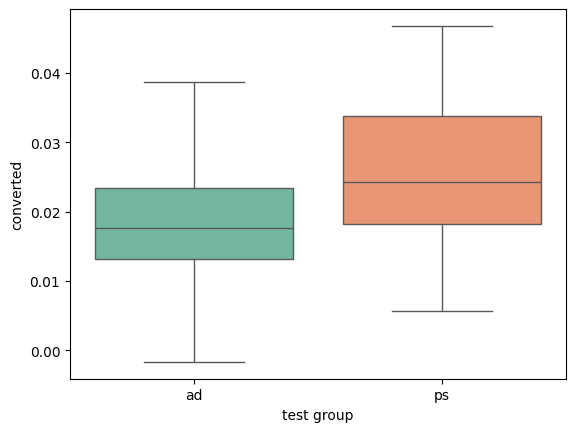

In [19]:
# Crear un boxplot
sns.boxplot(x='test group', y='converted', data=df_t, palette='Set2')

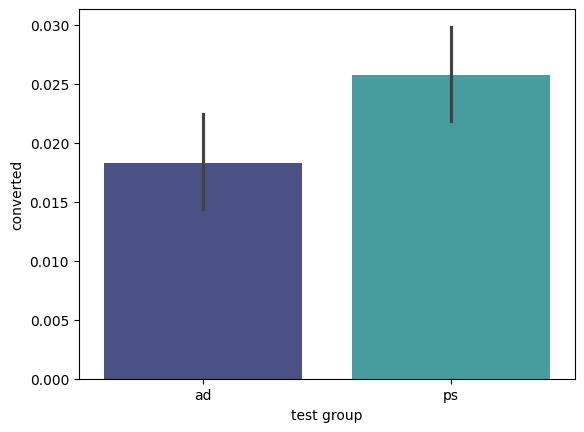

In [20]:
# antes de hacer la prueba estadística vemos si visualmente vemos diferencias entre los grupos
sns.barplot(x="test group", y="converted", data=df_t,  palette = "mako");

In [ ]:
# Extraer los títulos de la primera fila
titulos = df1.iloc[0]  # Primera fila contiene los títulos
# Asignar los títulos como nombres de las columnas
df1.columns = titulos
# Eliminar la primera fila (ya no es un dato útil, solo contenía los títulos)
df1 = df1[1:].reset_index(drop=True)
# Verificar el resultado
df1.head()

In [10]:
# Separar los grupos "ps" y "ad"
df_ps = df_t[df_t['test group'] == 'ps']  # Filtramos por el grupo "ps"
df_ad = df_t[df_t['test group'] == 'ad']  # Filtramos por el grupo "ad"

In [18]:
# Dividir los datos en grupos de control (ps) y grupo de prueba (ad)
control_group_t = df_t[df_t['test group'] == 'ps']['converted']
test_group_t = df_t[df_t['test group'] == 'ad']['converted']

# Realizar la prueba t de dos muestras independientes
t_stat, p_value = ttest_ind(control_group_t, test_group_t)

# Imprimir el resultado de la prueba
if p_value < 0.05:
    print("Hay una diferencia significativa en las tasas de conversión entre el grupo de control ('ps') y el grupo de prueba ('ad').")
    print("\n ---------- \n")
    print("""
          Los resultados sugieren que existe evidencia estadística para afirmar que las medias de las muestras son distintas. 
          Por lo tanto, el nuevo diseño de anuncio tiene un impacto significativo en las tasas de conversión y se puede 
          considerar para su implementación a gran escala.
          """)
else:
    print("No hay evidencia de una diferencia significativa en las tasas de conversión entre los grupos.")
    print("\n ---------- \n")
    print("""
          Los resultados sugieren que no existe evidencia estadística para afirmar que las medias de las muestras son distintas. 
          Por lo tanto, aunque se vean algunas diferencias entre el grupo 'ad' y el grupo 'ps', el análisis estadístico no sugiere 
          que estas diferencias sean lo suficientemente significativas como para justificar un cambio en el diseño del anuncio.
          """)

Hay una diferencia significativa en las tasas de conversión entre el grupo de control ('ps') y el grupo de prueba ('ad').

 ---------- 


          Los resultados sugieren que existe evidencia estadística para afirmar que las medias de las muestras son distintas. 
          Por lo tanto, el nuevo diseño de anuncio tiene un impacto significativo en las tasas de conversión y se puede 
          considerar para su implementación a gran escala.
          


In [12]:
# 1. Calcular la tasa de conversión para cada grupo
tc_ps = df_ps['converted'].mean()  # Promedio de CTR para el grupo "ps"
tc_ad = df_ad['converted'].mean()  # Promedio de CTR para el grupo "ad"

print(f"Tasa de conversión promedio para el grupo 'ps': {tc_ps:.4f}")
print(f"Tasa de conversión promedio para el grupo 'ad': {tc_ad:.4f}")

Tasa de conversión promedio para el grupo 'ps': 0.0257
Tasa de conversión promedio para el grupo 'ad': 0.0183


In [15]:
# 2. Realizar una prueba t de dos muestras independientes
# H0: No hay diferencia significativa en las tasas de conversión
# H1: Hay una diferencia significativa en las tasas de conversión

t_stat, p_value = stats.ttest_ind(df_ps['converted'], df_ad['converted'])
print("\nResultados de la prueba t:")
print(f"Estadístico t: {t_stat:.4f}")
print(f"Valor p: {p_value:.4f}")


Resultados de la prueba t:
Estadístico t: 2.4589
Valor p: 0.0176


# Ejercicio 2
En este caso, vamos a realizar un experimento para comparar la cantidad promedio de anuncios vistos por los usuarios en los grupos "ad" y "psa" y determinar si hay una diferencia significativa entre ellos.

  - Objetivo del experimento: Comparar la cantidad promedio de anuncios vistos por usuario entre los grupos de prueba "ad" y "psa" para determinar si el tipo de anuncio afecta la cantidad de anuncios que los usuarios ven.

  - Preparación de los datos: Asegúrate de que los datos estén limpios y listos para el análisis. Esto incluye la eliminación de datos faltantes y la verificación de la coherencia de los datos.

  - Hipótesis: Plantea una hipótesis nula (H0) y una hipótesis alternativa (H1) para el experimento. En este caso, las deberéis plantear vosotras

  - Prueba de hipótesis: Utiliza una prueba estadística, como la prueba t de Student, para comparar la cantidad promedio de anuncios vistos por usuario entre los grupos "ad" y "psa". Esto te permitirá determinar si hay una diferencia significativa entre los dos grupos.

  - Análisis de resultados:

     - Si el valor p (p-value) es menor que un umbral predefinido (por ejemplo, 0.05), rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en la cantidad promedio de anuncios vistos por usuario entre los grupos.

     - Si el valor p es mayor que el umbral, no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa.

  - Conclusiones y recomendaciones: Basándote en los resultados de la prueba de hipótesis, llega a una conclusión sobre si el tipo de anuncio (ad o psa) tiene un impacto significativo en la cantidad promedio de anuncios vistos por usuario. Si es así, puedes hacer recomendaciones basadas en estos hallazgos.

In [23]:
df['total ads'].isnull().sum()

np.int64(0)

In [26]:
df['total ads'].isna().sum()

np.int64(0)

In [22]:
# crear un diccionario con dos columnas, la del grupo a la que pertecen y otra con los valores de CTR (con una distribución normal)
data_t = {'test group': ['ad'] * 25 + ['ps'] * 25,
        'total ads' : np.concatenate([np.random.normal(0.02, 0.01, 25),
                               np.random.normal(0.025, 0.01, 25)])}

df_t = pd.DataFrame(data_t)
df_t.tail()

,test group,total ads
45,ps,0.028259
46,ps,0.034172
47,ps,0.011471
48,ps,0.012234
49,ps,0.014248


<Axes: xlabel='test group', ylabel='total ads'>

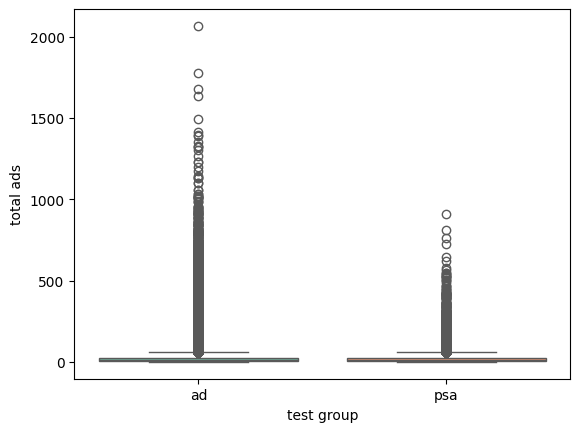

In [28]:
# Crear el Boxplot
sns.boxplot(x='test group', y='total ads', data=df, palette='Set2')